In [1]:
import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[1])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import scipy
import pickle
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns
import sigpy as sp
import cupy as cp
import numpy as np
from sigpy.mri.app import L1WaveletRecon


## My files
import save_data_helpers
import recon_functions
import recon_plot_helpers
import raw_data_utils

### Load gated data

In [2]:
idx_amp_all, resp_trimmed_amp_all, data_bins_amp_all, spoke_bins_amp_all, index_bins_amp_all = save_data_helpers.load_gate_outputs_pickle('/home/lilianae/projects/naf_clean/load_data_clean/subject2_mid0082/gates_amp_all_slices.pkl')

Loaded /home/lilianae/projects/naf_clean/load_data_clean/subject2_mid0082/gates_amp_all_slices.pkl
  idx shape: (113116,)
  signal_trimmed shape: (113116,)
  data_bins: 5 elements
  spoke_bins: 5 elements
  index_bins: 5 elements


In [3]:
from gating_functions import reshape_gate

data_bins_rshp = []
spoke_bins_rshp = []

for i in range(len(data_bins_amp_all)):
    data_bins_gate_rshp, spoke_bins_gate_rshp = reshape_gate(data_bins_amp_all[i],
                                                             spoke_bins_amp_all[i], 
                                                             num_coils=15,
                                                             num_slices=58,
                                                             num_samples=256,
                                                             ndims=3)
    data_bins_gate_rshp= data_bins_gate_rshp.transpose(0,2,1,3)
    spoke_bins_gate_rshp= spoke_bins_gate_rshp.transpose(1,0,2,3)
    print(data_bins_gate_rshp.shape)
    print(spoke_bins_gate_rshp.shape)
    data_bins_rshp.append(data_bins_gate_rshp)
    spoke_bins_rshp.append(spoke_bins_gate_rshp)

print(len(data_bins_rshp))
print(len(spoke_bins_rshp))

(15, 58, 390, 256)
(58, 390, 256, 3)
(15, 58, 390, 256)
(58, 390, 256, 3)
(15, 58, 390, 256)
(58, 390, 256, 3)
(15, 58, 390, 256)
(58, 390, 256, 3)
(15, 58, 390, 256)
(58, 390, 256, 3)
5
5


In [4]:
def crop_kspace(ksp_data, oshape, verbose=True):

    """
    Crop radial k-space data along center

    Inputs
    ------------------------------
    ksp_data : ndarray
        Radial k-space data of shape (ncoils, nslices, nspokes, nsamples)
    oshape: tuple
        Desired final image shape (Cartesian -> Nz, Ny, Nx) 
    verbose : bool
        Default = True, print variable shapes 

    Outputs
    --------------------------------
    ksp_data_cropped : ndarray
        K-space data reshaped as (ncoils, oshape[0], nspokes, oshape[1]/oshape[2])
    """
    ncoils, nslices, nspokes, nsamples = ksp_data.shape
    img_shape = (nslices, nsamples, nsamples)

    ## Given desired oshape, calculate where to crop data along radial spoke
    nz, ny, nx = oshape
    slices_center = nslices // 2
    samples_center = nsamples // 2

    slices_start = slices_center  - nz//2
    slices_end = slices_center  + nz//2

    samples_start = samples_center - ny // 2
    samples_end = samples_center + ny // 2

    ksp_data_cropped = []
    for c in range(ncoils):
        ksp_data_cropped.append(ksp_data[c, :, :, samples_start:samples_end])
    
    ksp_data_cropped = np.stack(ksp_data_cropped, axis=0)

    if verbose:
        print(f'Slices cropped from indices {slices_start} to {slices_end} ')
        print(f'Samples cropped from indices {samples_start} to {samples_end}')
        print(f'Cropped kspace shape = {ksp_data_cropped.shape}')

    return ksp_data_cropped


def crop_coords(coords, oshape, verbose=True):

    """
    Crop radial k-space data along center

    Inputs
    ------------------------------
    coords : ndarray
        GA coords of shape (nslices, nspokes, nsamples, ndims)
    oshape: tuple
        Desired final image shape (Cartesian -> Nz, Ny, Nx) 
    verbose : bool
        Default = True, print variable shapes 
    Outputs
    --------------------------------
    coords_cropped : ndarray
        Coords reshaped as (oshape[0], nspokes, oshape[1]/oshape[2], ndims)
    """
    nslices, nspokes, nsamples, ndims = coords.shape
    img_shape = (nslices, nsamples, nsamples)

    ## Given desired oshape, calculate where to crop data along radial spoke
    nz, ny, nx = oshape

    slices_center = nslices // 2
    samples_center = nsamples // 2

    slices_start = slices_center  - nz//2
    slices_end = slices_center  + nz//2

    samples_start = samples_center - ny // 2
    samples_end = samples_center + ny // 2

    coords_cropped = coords[:, :, samples_start:samples_end, :]

    # for dim in range(ndims):
    #     coord_min = coords_cropped[...,dim].min()
    #     coord_max = coords_cropped[...,dim].max()
    #     coords_center = (coord_min + coord_max) / 2 
    #     coords_cropped[...,dim] -= coords_center
        


    if verbose:
        print(f'Slices cropped from indices {slices_start} to {slices_end} ')
        print(f'Samples cropped from indices {samples_start} to {samples_end}')
        print(f'Cropped coords shape = {coords_cropped.shape}')
    return coords_cropped



def crop_ksp_and_coords_gates(data_bins, spoke_bins, oshape, verbose=True):

    """
    Crop gated k-space data and coordinates along center

    Inputs
    ------------------------------
    data_bins: list
        List of arrays, each array = radial k-space data of shape (ncoils, nslices, nspokes, nsamples)
    coord_bins: list
        List of arrays, each array = radial coordinates corresponding to ksp, shape (nspokes, nslices, nsamples, ndims)
    oshape: tuple
        Desired final image shape (Cartesian -> Nz, Ny, Nx) 
    verbose : bool
        Default = True, print variable shapes 
    Outputs
    --------------------------------
    data_bins_cropped : list
        List of arrays, each array = radial k-space data reshaped as (ncoils, oshape[0], nspokes, oshape[1]/oshape[2])
    coord_bins_cropped : list
        List of arrays, each array = GA coordinates for ksp bin, shape = (nspokes, oshape[0], oshape[1]/oshape[2], ndims)
    """
    num_gates = len(data_bins)
    data_bins_cropped = []
    spoke_bins_cropped = []

    for gate_idx in range(num_gates):
        data_bin_cropped = crop_kspace(data_bins[gate_idx], oshape=oshape, verbose=verbose)
        coord_bin_cropped = crop_coords(spoke_bins[gate_idx], oshape=oshape, verbose=verbose)
        data_bins_cropped.append(data_bin_cropped)
        spoke_bins_cropped.append(coord_bin_cropped)
    return data_bins_cropped, spoke_bins_cropped


In [5]:
oshape = (12, 24, 24)

data_bins_cropped, spoke_bins_cropped = crop_ksp_and_coords_gates(data_bins_rshp,
                                                                  spoke_bins_rshp,
                                                                  oshape=oshape, verbose=False)

print(f'data_bins_cropped[0].shape = {data_bins_cropped[0].shape}')
print(f'spoke_bins_cropped[0].shape = {spoke_bins_cropped[0].shape}')
print(f'len(data_bins_cropped) = {len(data_bins_cropped)}')
print(f'len(spoke_bins_cropped) = {len(spoke_bins_cropped)}')

data_bins_cropped[0].shape = (15, 58, 390, 24)
spoke_bins_cropped[0].shape = (58, 390, 24, 3)
len(data_bins_cropped) = 5
len(spoke_bins_cropped) = 5


In [6]:
coord = spoke_bins_cropped[0]
for i in range(3):
    print(f"Dim {i}: min={coord[..., i].min():.2f}, max={coord[..., i].max():.2f}, range={coord[..., i].max() - coord[..., i].min():.2f}")

Dim 0: min=-29.00, max=29.00, range=58.00
Dim 1: min=-11.55, max=11.55, range=23.09
Dim 2: min=-11.55, max=11.55, range=23.09


In [19]:
shape = (58, 24, 24)
ndim = 3
oversamp = 1.25
print(list(shape)[:-ndim] + [shape[-ndim]] + [int(np.ceil(oversamp * i)) for i in shape[-ndim+1:]])

[58, 30, 30]


In [20]:
from sigpy.mri import dcf

def _scale_coord(coord, shape, oversamp):
    """" Scale coordinates """
    ndim = coord.shape[-1]
    output = coord.copy()

    for i in range(-ndim, 0):
        scale = np.ceil(oversamp * shape[i]) / shape[i]
        shift = np.ceil(oversamp * shape[i]) // 2
        output[..., i] *= scale
        output[..., i] += shift

    return output


def _get_oversamp_shape(shape, ndim, oversamp):
    """Changed this for gated data"""
    return list(shape)[:-ndim] + [shape[-ndim]] + [int(np.ceil(oversamp * i)) for i in shape[-ndim+1:]]

def _estimate_shape(coord):
    """Estimate array shape from coordinates.

    Shape is estimated by the different between maximum and minimum of
    coordinates in each axis.

    Args:
        coord (array): Coordinates.
    """
    ndim = coord.shape[-1]
    with sp.backend.get_device(coord):
        shape = [int(coord[..., i].max() - coord[..., i].min())
                 for i in range(ndim)]

    return shape

def sigpy_gridding(input, coord, oshape=None, oversamp=1.25, width=4):
    ndim = coord.shape[-1]
    beta = np.pi * (((width / oversamp) * (oversamp - 0.5))**2 - 0.8)**0.5
    if oshape is None:
        oshape = list(input.shape[:-coord.ndim + 1]) + _estimate_shape(coord)
    else:
        oshape = list(oshape)

    os_shape = _get_oversamp_shape(oshape, ndim, oversamp)

    print(f'os_shape = {os_shape}')

    # Gridding
    coord = _scale_coord(coord, oshape, oversamp)
    output = sp.interp.gridding(input, coord, os_shape,
                             kernel='kaiser_bessel', width=width, param=beta)
    output /= width**ndim

    return output


def grid_kspace(ksp_data, coords, img_shape=None, dcf_weights=None, verbose=True):
    """" 
    Grid non-Cartesian kspace 

    Inputs
    ----------------------
    ksp_data : ndarray
        Shape (ncoils, nslices, nspokes, nsamples)
    coords : ndarray
        Shape (nslices, nspokes, nsamples, ndims)
    img_shape : tuple, Optional
        Desired img_shape, if None img_shape is inferred
    dcf_weights : ndarray, Optional
        Shape (nslices, nspokes, nsamples). If None sigpy.pipe_menon used
    verbose : bool
        Default = True, print output shapes

    Outputs 
    -----------------------
    ksp_gridded : ndarray
        Gridded ksp of shape (ncoils, Nz, Ny, Nx)
    """
    ncoils, nslices, nspokes, nsamples = ksp_data.shape
    if img_shape is None:
        img_shape = (nslices, nsamples, nsamples)

    dcf_ksp = dcf.pipe_menon_dcf(coords, img_shape)
    ksp_gridded = sigpy_gridding(ksp_data*dcf_ksp, coord=coords)
    if verbose:
        print(f'ksp_gridded.shape = {ksp_gridded.shape}')
    return ksp_gridded


def grid_ksp_gates(data_bins, spoke_bins, img_shape=None, dcf_weights=None, verbose=True):
    """" 
    Grid non-Cartesian kspace gates with corresponding gated GA coords  

    Inputs
    ----------------------
    data_bins : list
        List of ndarays, each has shape (ncoils, nslices, nspokes, nsamples)
    spoke_bins : list
        List of ndarrays, each has shape (nslices, nspokes, nsamples, ndims)
    img_shape : tuple, Optional
        Desired img_shape, if None img_shape is inferred
    dcf_weights : ndarray, Optional
        Shape (nslices, nspokes, nsamples). If None sigpy.pipe_menon used
    verbose : bool
        Default = True, print output shapes

    Outputs 
    -----------------------
    data_bins_gridded : list
        List, each element = gridded ksp of shape (ncoils, Nz, Ny, Nx)
    """
    num_gates = len(data_bins)
    all_data_bins_gridded = []

    ncoils, nslices, nspokes, nsamples = data_bins[0].shape
    if img_shape is None:
        img_shape = (nslices, nsamples, nsamples)
        if verbose:
            print(f'Estimated img_shape = {img_shape}')
    
    for gate_idx in range(num_gates):
        data_bin = data_bins[gate_idx]
        spoke_bin = spoke_bins[gate_idx]
        data_bin_gridded = grid_kspace(data_bin, spoke_bin, img_shape=img_shape,
                                       dcf_weights=dcf_weights, verbose=verbose)
        all_data_bins_gridded.append(data_bin_gridded)

    return all_data_bins_gridded




In [21]:
print(spoke_bins_cropped[0].shape)

(58, 390, 24, 3)


In [22]:
coord = spoke_bins_cropped[0]
ndim = coord.shape[-1]
with sp.backend.get_device(coord):
    shape = [int(coord[..., i].max() - coord[..., i].min())
                for i in range(ndim)]
    print(shape)


[58, 23, 23]


In [23]:
all_data_bins_gridded = grid_ksp_gates(data_bins_cropped, spoke_bins_cropped)

Estimated img_shape = (58, 24, 24)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

os_shape = [15, 58, 29, 29]
ksp_gridded.shape = (15, 58, 29, 29)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

os_shape = [15, 58, 29, 29]
ksp_gridded.shape = (15, 58, 29, 29)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

os_shape = [15, 58, 29, 29]
ksp_gridded.shape = (15, 58, 29, 29)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

os_shape = [15, 58, 29, 29]
ksp_gridded.shape = (15, 58, 29, 29)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

os_shape = [15, 58, 29, 29]
ksp_gridded.shape = (15, 58, 29, 29)


In [25]:
print(all_data_bins_gridded[0].shape)

(15, 58, 29, 29)


### Sanity check

In [27]:
ncoils, nslices, nspokes, nsamples = data_bins_cropped[0].shape
img_shape = (nslices, nsamples, nsamples)
coord = spoke_bins_cropped[0]
dcf_ksp = dcf.pipe_menon_dcf(coord, img_shape)
img_grid = sp.nufft_adjoint(data_bins_cropped[0] * dcf_ksp, coord)

PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

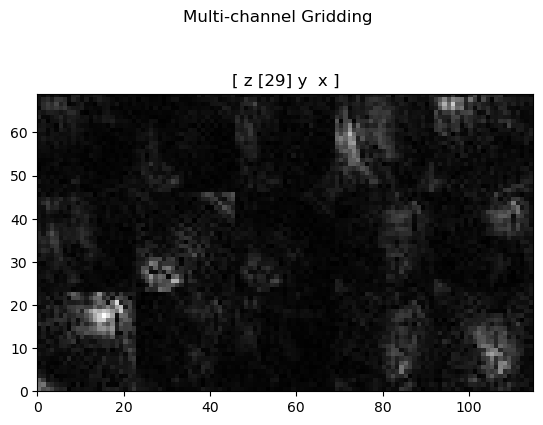

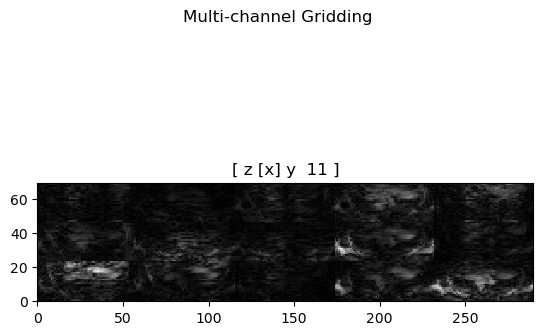

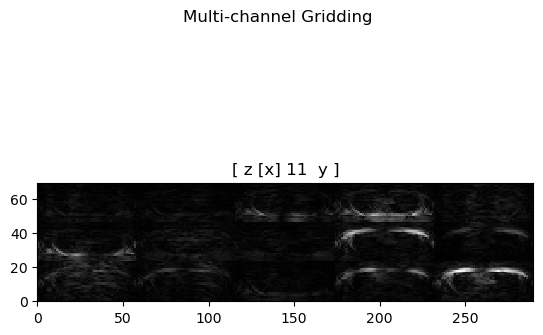

In [28]:
import sigpy.plot as pl

pl.ImagePlot(img_grid, z=0, title='Multi-channel Gridding')
pl.ImagePlot(img_grid, x=1, y=2, z=0, title='Multi-channel Gridding')
pl.ImagePlot(img_grid, x=1, y=3, z=0, title='Multi-channel Gridding')

### Quick gridding

In [61]:
espirit_mps_coilsens = mri.app.EspiritCalib(all_data_bins_gridded[0], calib_width=19, kernel_width=4, thresh=0.05, crop=0.80).run()
print(f'Done calculating 2D Espirit maps, espirit_mps_coilsens.shape = {espirit_mps_coilsens.shape}')

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

Done calculating 2D Espirit maps, espirit_mps_coilsens.shape = (15, 58, 29, 29)


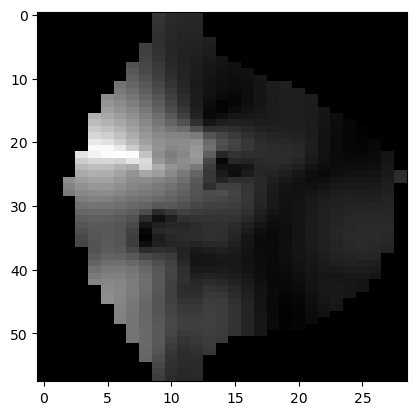

In [62]:
import matplotlib.pyplot as plt
# img = espirit_mps_coilsens[10, 58//2, :, :]
img = espirit_mps_coilsens[7, :, :, 29//2]
aspect = 29/58
plt.imshow(np.abs(img), cmap='gray', aspect=aspect)

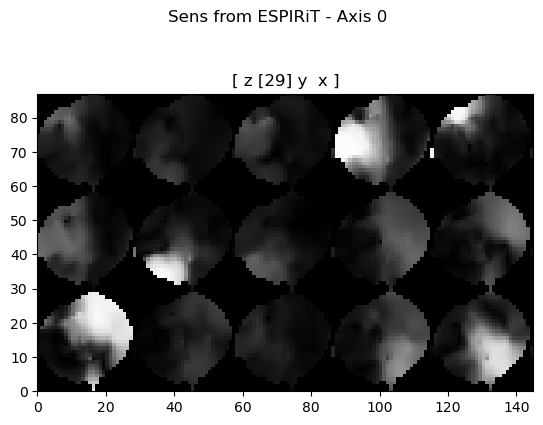

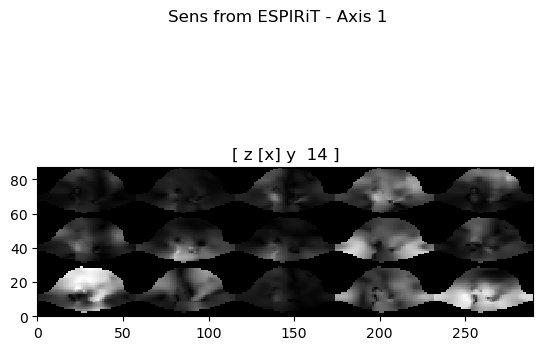

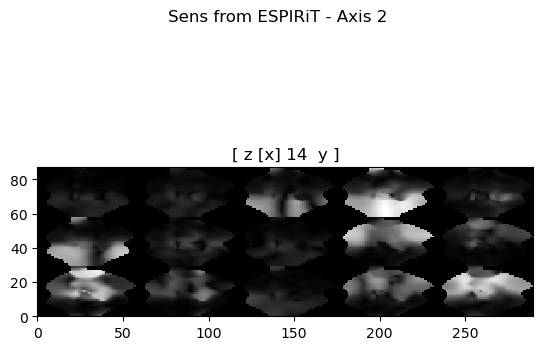

In [63]:
pl.ImagePlot(espirit_mps_coilsens, z=0, title='Sens from ESPIRiT - Axis 0')
pl.ImagePlot(espirit_mps_coilsens, x=1, y=2, z=0, title='Sens from ESPIRiT - Axis 1')
pl.ImagePlot(espirit_mps_coilsens, x=1, y=3, z=0, title='Sens from ESPIRiT - Axis 2')

In [ ]:
from scipy.ndimage import zoom
from scipy.signal import get_window
from scipy.ndimage import gaussian_filter

def hamming_filter_3d(ksp_data, window_size=(7, 15, 15)):
    ### APPLY THIS IN IMAGE DOMAIN
    ## Create 3D Hamming window
    wz = get_window('hamming', window_size[0])
    wy = get_window('hamming', window_size[1])
    wx = get_window('hamming', window_size[2])

    ## Create 3D window by outer product
    kernel_3d = np.outer(wz, np.outer(wx, wy).flatten()).reshape(window_size)

    ## Normalize kernel
    kernel_3d = kernel_3d / np.sum(kernel_3d)

    ## Apply convolution
    filtered_ksp = ndimage.convolve(ksp_data, kernel_3d, mode='constant', cval=0.0)

    return filtered_ksp

def apply_hamming_filter(ksp_data, window_size=(7, 15, 15)):
    ncoils, nz, ny, nx = ksp_data.shape
    filtered_ksp = np.zeros(ksp_data.shape, dtype=complex)
    for coil in tqdm(range(ncoils), desc="Processing coils"):
        single_coil_filtered = hamming_filter_3d(ksp_data[coil], window_size)
        filtered_ksp[coil] = single_coil_filtered

    return filtered_ksp
 

def mps_reshape(mps, oshape):
    ncoils = len(mps)
    ## Get dims of current image and desired shape
    Nz, Ny, Nx = mps[0].shape
    new_Nz, new_Ny, new_Nx = oshape

    ## Calculate zoom factors
    zoom_factors = [new_Nz/Nz, new_Ny/Ny, new_Nx/Nx]

    mps_reshaped = np.zeros((ncoils, *oshape), dtype=complex)
    ndims = mps[0].ndim
    print(f'{ndims} dims')

    # mps_hamming = ndimage.gaussian_filter(mps, sigma=(4.0, 6.0, 6.0))
    for coil in range(ncoils):
        mag = np.abs(mps[coil])
        phase = np.angle(mps[coil])

        filter_mag = ndimage.gaussian_filter(mag, sigma=(1.0, 1.5, 1.5))
        filter_phase = ndimage.gaussian_filter(phase, sigma=1.0 )

        new_mag = zoom(filter_mag, zoom_factors)
        new_phase = zoom(filter_phase, zoom_factors)

        mps_reshaped[coil] = new_mag * np.exp(1j*new_phase)

    return mps_reshaped


mps_reshaped = mps_reshape(espirit_mps_coilsens, oshape=(72, 256, 256))
print(f'mps_rehsaped.shape = {mps_reshaped.shape}')